In [54]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F  #for the activation function

In [30]:
latent_repVIDEO  = np.load('latent_repVIDEO.npy')
latent_repWFIELD = np.load('latent_repWFIELD.npy')
len_VIDEO        = np.size(latent_repVIDEO,1)
len_WFIELD       = np.size(latent_repWFIELD,1)
mean_VIDEO       = np.mean(latent_repVIDEO,0)
mean_WFIELD      = np.mean(latent_repWFIELD,0)
pca_VIDEO        = PCA(len_VIDEO)
pca_WFIELD       = PCA(len_WFIELD)
latent_repVIDEO  = latent_repVIDEO-mean_VIDEO
latent_repWFIELD = latent_repWFIELD-mean_WFIELD

In [31]:
latent_VIDE0_pca  = pca_VIDEO.fit_transform(latent_repVIDEO)

In [65]:
class VAE(nn.Module):
    def __init__(self,latent_dim1, latent_dim2, batch_size,use_mse_loss=True):
        super(VAE,self).__init__()
        self.latent_dim1 = latent_dim1
        self.latent_dim2 = latent_dim2
        self.batch_size = batch_size
        self.use_mse_loss = use_mse_loss
        
        ## Encoder set1(VIDEO)
        self.set1_enc1 = nn.Linear(in_features = dim_VIDEO,out_features = 512)
        self.set1_enc2 = nn.Linear(in_features = 512,out_features = 128)
        self.set1_enc3 = nn.Linear(in_features = 128,out_features = 2*latent_dim1) 
        ## Decoder set1(VIDEO)
        self.set1_dec1 = nn.Linear(in_features = latent_dim1,out_features = 128)
        self.set1_dec2 = nn.Linear(in_features = 128,out_features = 512)
        self.set1_dec3 = nn.Linear(in_features = 512,out_features = dim_VIDEO)
        ## Encoder set2(WFIELD)
        # input size: 1x2 x 135 x 160
        self.set2_enc1 = nn.Conv2d(in_channels=2, out_channels=latent_dim2, kernel_size=4, stride=2, padding=1)
        # size: 1x16 x 67 x 80
        self.set2_enc2 = nn.Conv2d(in_channels=latent_dim2, out_channels=latent_dim2, kernel_size=4, stride=2, padding=1)
        # size: 1x16 x 33 x 40
        self.set2_enc3 = nn.Conv2d(in_channels=latent_dim2, out_channels=latent_dim2, kernel_size=10, stride=(6,8), padding=1)
        # size: 16 x 5 x 5   
        ## Decoder set2(WFIELD)
        # input size: 16x1x1
        self.set2_dec0 = nn.ConvTranspose2d(in_channels=latent_dim2,out_channels=latent_dim2, kernel_size=5, stride=2, padding=0)
        # input size: 16x5x5
        self.set2_dec1 = nn.ConvTranspose2d(in_channels=latent_dim2,out_channels=latent_dim2, kernel_size=10, stride=(6,8), padding=1,output_padding=(1,0))
        # size: 16 x 33 x 40
        self.set2_dec2 = nn.ConvTranspose2d(in_channels=latent_dim2,out_channels=2, kernel_size=6, stride=4, padding=1,output_padding=(3,0))
        # size: 16 x 135 x 160
        
        self.VIDEOc1 = nn.Conv2d(latent_dim2, latent_dim2, 4, 2, 0)
        # size: 16 x 1 x 1
        self.VIDEOc2 = nn.Conv2d(latent_dim2, latent_dim2, 4, 2, 0)
        # size: 16 x 1 x 1
        self.register_parameter(name='g11', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.register_parameter(name='g22', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.flag_initialize= 1
        self.g12= torch.zeros(latent_dim1,latent_dim2).to(device)
    def forward(self,data1,data2):
        data2 = data2.unsqueeze(2)
        data2 = data2.unsqueeze(3)
        # decoding for VIDEO
        x1 = F.relu(self.set1_dec1(data1))
        x1 = self.set1_dec2(x1)
        # decoding for WFIELD
        x2 = F.relu(self.set2_dec0(data2))
        x2 = F.relu(self.set2_dec1(x2))
        reconstruction1 = self.set1_dec3(x1)
        reconstruction2 = self.set2_dec2(x2).view(-1,dim_WFIELD)
        return reconstruction1,reconstruction2

In [66]:
PATH = "/home/achint/Practice_code/models_parameters/video_wfield/untitled.txt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
state = torch.load(PATH)
latent_dim1 = 32
latent_dim2 = 16
batch_size  = 1
dim_VIDEO   = 19200
dim_WFIELD   = 2* 135* 160
model = VAE(latent_dim1, latent_dim2, batch_size,use_mse_loss=True).to(device)
model.load_state_dict(state['state_dict'])
for name, para in model.named_parameters():
    print(name)

g11
g22
set1_enc1.weight
set1_enc1.bias
set1_enc2.weight
set1_enc2.bias
set1_enc3.weight
set1_enc3.bias
set1_dec1.weight
set1_dec1.bias
set1_dec2.weight
set1_dec2.bias
set1_dec3.weight
set1_dec3.bias
set2_enc1.weight
set2_enc1.bias
set2_enc2.weight
set2_enc2.bias
set2_enc3.weight
set2_enc3.bias
set2_dec0.weight
set2_dec0.bias
set2_dec1.weight
set2_dec1.bias
set2_dec2.weight
set2_dec2.bias
VIDEOc1.weight
VIDEOc1.bias
VIDEOc2.weight
VIDEOc2.bias


In [78]:
data1 =torch.from_numpy(latent_VIDE0_pca).to(device)
data2 =torch.from_numpy(latent_repWFIELD).to(device)
reconstruction1,reconstruction2 = model(data1,data2)

RuntimeError: CUDA out of memory. Tried to allocate 632.00 MiB (GPU 0; 10.91 GiB total capacity; 7.54 GiB already allocated; 96.38 MiB free; 7.57 GiB reserved in total by PyTorch)

In [87]:
reconstruction1_reshape = reconstruction1[1].view(batch_size, 1, 160, 120)
reconstruction2_reshape = reconstruction2[1].view(batch_size, 2, 135, 160)

In [107]:
rec1 = reconstruction1_reshape.cpu().detach().numpy()
rec2 = reconstruction2_reshape.cpu().detach().numpy()

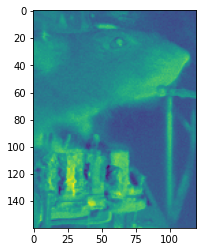

In [113]:
plt.imshow(rec1[0,0,:,:])